# Tanzanian Water Well Conditions - Final

This is the process by which I generated a Random Forest Classifier ("RFC") model to classify water wells using data from both Taarifa and the Tanzanian Ministry of Water.

The water wells are divided up into three different categories, using the following labels: `Functional`, `Non-functional`, and `Functional, needs repair`. The goal is to be able to accurately predict which category each well falls into, based on a variety of factors, such as the kind of pump in operation, when it was installed, and the size of the surrounding population. Understanding which wells might fail will help the government and NGOs on the ground keep up with maintenance and ensure access to water to as many communities as possible.

What follows are my steps that lead me to my final model.

## Importing Libraries and Data

#### Libraries

In [1]:
#General libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#Modeling libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.utils import resample

#### Data

In [2]:
#training labels
train_label = pd.read_csv('train_labels.csv')
train_label.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

In [3]:
#training predictors
train_values = pd.read_csv('train_values.csv')
train_values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
df = pd.merge(train_label, train_values, how='left')

## Data Exploration and Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                       59400 non-null int64
status_group             59400 non-null object
amount_tsh               59400 non-null float64
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
longitude                59400 non-null float64
latitude                 59400 non-null float64
wpt_name                 59400 non-null object
num_private              59400 non-null int64
basin                    59400 non-null object
subvillage               59029 non-null object
region                   59400 non-null object
region_code              59400 non-null int64
district_code            59400 non-null int64
lga                      59400 non-null object
ward                     59400 non-null object
population               59400 non-null int64
p

The following are true about the training dataset:
- There are 40 columns (not including the labels)
    - Of those 40 columns, there are:
        - Float = 3
        - Int = 7
        - Object = 30
    - Information included in these columns:
        - Geographic information, like coordinates, region/village, and elevation
        - Water quality and water source
        - Installation data (when it was installed, who installed it)
        - Who maintains the well
        - Population that uses the well
        - and some other adminstrative details
- There are a maximum of 59,400 rows, some of which are missing data.

#### Removing Columns - Round 1

In [6]:
#Used for checking value counts of various columns
var = 'amount_tsh'
print(len(df[var].unique()))
df[var].value_counts()

98


0.00         41639
500.00        3102
50.00         2472
1000.00       1488
20.00         1463
200.00        1220
100.00         816
10.00          806
30.00          743
2000.00        704
250.00         569
300.00         557
5000.00        450
5.00           376
25.00          356
3000.00        334
1200.00        267
1500.00        197
6.00           190
600.00         176
4000.00        156
2400.00        145
2500.00        139
6000.00        125
7.00            69
8000.00         61
750.00          59
40.00           59
10000.00        57
12000.00        51
             ...  
16000.00         2
16300.00         2
800.00           2
11000.00         2
590.00           2
520.00           2
26000.00         2
13000.00         2
9.00             1
170000.00        1
200000.00        1
900.00           1
0.25             1
53.00            1
350000.00        1
306.00           1
120000.00        1
26.00            1
59.00            1
60000.00         1
5400.00          1
70000.00    

In [7]:
remove = ['wpt_name', 'num_private', 'subvillage', 'region_code', 'district_code',
         'lga', 'ward', 'recorded_by', 'scheme_name', 'latitude', 'longitude', 'amount_tsh']

df.drop(columns=remove, inplace=True)

The reasons for dropping the columns above from the original dataframe are listed below. The descision to remove these columns was made by examining the `.value_counts()` for each column.

1. `wpt_name` - names for the wells, too many levels
2. `num_private` - not sure what this is
3. `subvillage` - too many levels
4. `region_code` - a proxy for region
5. `district_code` - too many levels, also kind of a proxy for region
6. `lga` - too many levels, also kind of a proxy for region
7. `ward` - too many levels, also kind of a proxy for region
8. `recorded_by` - constant
9. `scheme_name` - too many levels, and missing almost half of data
10. `latitude` and `longitude` - variables are too specific for each well
11. `amount_tsh` - unsure what the variable represents

#### Removing Columns - Round 2

With some of the easier columns to identify for removal, we need to look closer at some groups of columns, as there seems to be some duplication.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 29 columns):
id                       59400 non-null int64
status_group             59400 non-null object
date_recorded            59400 non-null object
funder                   55765 non-null object
gps_height               59400 non-null int64
installer                55745 non-null object
basin                    59400 non-null object
region                   59400 non-null object
population               59400 non-null int64
public_meeting           56066 non-null object
scheme_management        55523 non-null object
permit                   56344 non-null object
construction_year        59400 non-null int64
extraction_type          59400 non-null object
extraction_type_group    59400 non-null object
extraction_type_class    59400 non-null object
management               59400 non-null object
management_group         59400 non-null object
payment                  59400 non-null object
pa

In [9]:
def value_check(df, cols):
    """A function used to take a closer look at duplicative columns.
    Prints out a value_check() for each column in a list.
    
    Parameters:
    df (dataframe): a dataframe with the data of interest
    cols (list): a list of columns to compare"""
    
    for col in cols:
        print("Values for column: {}".format(col))
        print("Number of factors: {}".format(len(df[col].unique())))
        print(df[col].value_counts())
        print('\n')

In [10]:
# Extraction_type, Extraction_type_group, or Extraction_type_class
cols = ['extraction_type', 'extraction_type_group', 'extraction_type_class']
value_check(train_values, cols)

Values for column: extraction_type
Number of factors: 18
gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: extraction_type, dtype: int64


Values for column: extraction_type_group
Number of factors: 13
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump   

All three of these columns classify these columns in essentially the same way, but I'm only going to keep `extraction_type_class` as it has fewer levels than the other two columns.

In [11]:
# Basin or region
cols = ['basin', 'region']
value_check(train_values, cols)

Values for column: basin
Number of factors: 9
Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64


Values for column: region
Number of factors: 21
Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: region, dtype: int64




Basin and region are both different variables depicting which area of the country the well is located. Since `basin` has fewer possibilities, I'm going to keep that one and remove `region`.

In [12]:
# Scheme_management, management or management_group
cols = ['scheme_management', 'management', 'management_group']
value_check(train_values, cols)

Values for column: scheme_management
Number of factors: 13
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64


Values for column: management
Number of factors: 12
vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: management, dtype: int64


Values for column: management_group
Number of factors: 5
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: management_group, dtype: int6

Keeping `management`.

In [13]:
# Payment or payment_type
cols = ['payment', 'payment_type']
value_check(train_values, cols)

Values for column: payment
Number of factors: 7
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: payment, dtype: int64


Values for column: payment_type
Number of factors: 7
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: payment_type, dtype: int64




Exact same, keeping `payment`.

In [14]:
# Water_quality or quality_group
cols = ['water_quality', 'quality_group']
value_check(train_values, cols)

Values for column: water_quality
Number of factors: 8
soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: water_quality, dtype: int64


Values for column: quality_group
Number of factors: 6
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: quality_group, dtype: int64




Removing `water_quality`, almost the exact same as `quality_group`.

In [15]:
# Quantity or quantity_group
cols = ['quantity', 'quantity_group']
value_check(train_values, cols)

Values for column: quantity
Number of factors: 5
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity, dtype: int64


Values for column: quantity_group
Number of factors: 5
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: quantity_group, dtype: int64




Exact same, keeping `quantity`.

In [16]:
# Source, source_type, or source_class
cols = ['source', 'source_type', 'source_class']
value_check(train_values, cols)

Values for column: source
Number of factors: 10
spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: source, dtype: int64


Values for column: source_type
Number of factors: 7
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: source_type, dtype: int64


Values for column: source_class
Number of factors: 3
groundwater    45794
surface        13328
unknown          278
Name: source_class, dtype: int64




Keeping `source_type` and removing the others.

In [17]:
# waterpoint_type or waterpoint_type_group
cols = ['waterpoint_type', 'waterpoint_type_group']
value_check(train_values, cols)

Values for column: waterpoint_type
Number of factors: 7
communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: waterpoint_type, dtype: int64


Values for column: waterpoint_type_group
Number of factors: 6
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: waterpoint_type_group, dtype: int64




Removing `waterpoint_type_group`.

In [18]:
cols = ['scheme_management']
value_check(train_values, cols)

Values for column: scheme_management
Number of factors: 13
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
None                    1
Name: scheme_management, dtype: int64




In [19]:
#columns to remove
remove = ['extraction_type', 'extraction_type_group', 'region', 'management_group',
          'payment_type', 'water_quality', 'quantity_group', 'source', 'source_class',
          'waterpoint_type_group', 'scheme_management']

df_1 = df.drop(columns=remove, axis=1)

Columns removed in second round:

1. `extraction_type`
2. `extraction_type_group`
3. `region`
4. `management_group`
5. `payment_type`
6. `water_quality`
7. `quantity_group`
8. `source`
9. `source_class`
10. `waterpoint_type_group`
11. `scheme_management`

#### Cleaning up the resulting predictor columns

In [20]:
#removing missing values
df_1.dropna(inplace=True)
df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52057 entries, 0 to 59399
Data columns (total 18 columns):
id                       52057 non-null int64
status_group             52057 non-null object
date_recorded            52057 non-null object
funder                   52057 non-null object
gps_height               52057 non-null int64
installer                52057 non-null object
basin                    52057 non-null object
population               52057 non-null int64
public_meeting           52057 non-null object
permit                   52057 non-null object
construction_year        52057 non-null int64
extraction_type_class    52057 non-null object
management               52057 non-null object
payment                  52057 non-null object
quality_group            52057 non-null object
quantity                 52057 non-null object
source_type              52057 non-null object
waterpoint_type          52057 non-null object
dtypes: int64(4), object(14)
memory usage: 7.5+ M

In [21]:
df_1.construction_year.value_counts().head()

0       17413
2008     2509
2009     2431
2010     2142
2007     1516
Name: construction_year, dtype: int64

In [22]:
#replacing zeroes in construction year with median
med_cy = df_1.construction_year.median()
df_2 = df_1.replace({'construction_year': {0: med_cy}})

In [23]:
df_1.gps_height.value_counts()

 0       17358
-15         54
 303        51
-13         49
 1290       48
-16         48
-18         46
 320        43
-14         43
 1295       43
-19         42
-8          42
-6          41
 309        41
 280        41
-23         41
-11         40
-20         40
 1152       40
 336        40
 1304       39
 338        39
 1286       38
 306        38
-9          38
 1317       38
 259        38
 1330       37
-7          37
-21         37
         ...  
 2321        1
 2257        1
 2015        1
 591         1
 2236        1
 2332        1
 2286        1
 2254        1
 2364        1
 2022        1
 592         1
 577         1
-59          1
 2567        1
 2770        1
 2628        1
 2322        1
 2333        1
 2365        1
 2451        1
 2557        1
 2323        1
 2291        1
 2055        1
 2576        1
-90          1
 2128        1
 2407        1
 2535        1
 2536        1
Name: gps_height, Length: 2426, dtype: int64

On second thought, I'm going to remove `gps_height` from the predictor columns. I'm not quite sure what to do with the zeroes (as some of them probably are at an elevation of zero, while others are probably using zero as a missing value). There are also negative elevations in that column, which is another reason to drop it.

In [24]:
#removing rows with Nones or unknowns
df_3 = df_2[df_2['management'] != 'unknown']
df_model = df_3[df_3['quantity'] != 'unknown']
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51460 entries, 0 to 59399
Data columns (total 18 columns):
id                       51460 non-null int64
status_group             51460 non-null object
date_recorded            51460 non-null object
funder                   51460 non-null object
gps_height               51460 non-null int64
installer                51460 non-null object
basin                    51460 non-null object
population               51460 non-null int64
public_meeting           51460 non-null object
permit                   51460 non-null object
construction_year        51460 non-null float64
extraction_type_class    51460 non-null object
management               51460 non-null object
payment                  51460 non-null object
quality_group            51460 non-null object
quantity                 51460 non-null object
source_type              51460 non-null object
waterpoint_type          51460 non-null object
dtypes: float64(1), int64(3), object(14)
memory

#### Creating new variable

In [25]:
#this new column will record the number of days since 
#January 1st, 2014 the well was last inspected
df_model['days_since'] = pd.to_numeric(pd.to_datetime('2014-01-01') - pd.to_datetime(df_model['date_recorded']))/86400000000000

#### Reducing Factors

In [26]:
#Reducing the number of levels in the installer and funder variables
inst = df_model.installer.value_counts()
inst_vals = inst[:10].index
df_model['Installer'] = df_model.installer.where(df_model.installer.isin(inst_vals), "Other")

fund = df_model.funder.value_counts()
fund_vals = fund[:10].index
df_model['Funder'] = df_model.funder.where(df_model.funder.isin(fund_vals), "Other")

In [27]:
drop = ['funder', 'installer']
df_model.drop(columns=drop, inplace=True)

## Model Preprocessing

In [28]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51460 entries, 0 to 59399
Data columns (total 19 columns):
id                       51460 non-null int64
status_group             51460 non-null object
date_recorded            51460 non-null object
gps_height               51460 non-null int64
basin                    51460 non-null object
population               51460 non-null int64
public_meeting           51460 non-null object
permit                   51460 non-null object
construction_year        51460 non-null float64
extraction_type_class    51460 non-null object
management               51460 non-null object
payment                  51460 non-null object
quality_group            51460 non-null object
quantity                 51460 non-null object
source_type              51460 non-null object
waterpoint_type          51460 non-null object
days_since               51460 non-null float64
Installer                51460 non-null object
Funder                   51460 non-null object

#### Target and predictors

In [29]:
#Target variable
target = df_model.status_group.map({'functional': 1, 'non functional': 0,
                                    'functional needs repair': 2})

#Predictors
pred_cols = ['basin', 'population', 'public_meeting',
            'permit', 'construction_year', 'extraction_type_class', 'management',
            'payment', 'quality_group', 'quantity', 'source_type', 'waterpoint_type',
            'days_since', 'Installer', 'Funder']

predictors = df_model[pred_cols]

#### Get Dummies

In [30]:
new_preds = pd.get_dummies(predictors, drop_first=True)

#### Multicolinearity Check

In [31]:
corr_df = pd.DataFrame(new_preds.corr()[abs(new_preds.corr()) > 0.8])
corr_df.reset_index(inplace=True)
corr_df = pd.melt(corr_df, id_vars='index')
corr_df[corr_df.value < 1.0]

,index,variable,value
1027,waterpoint_type_hand pump,extraction_type_class_handpump,0.948206
2738,quality_group_salty,quality_group_good,-0.811439
2886,quality_group_good,quality_group_salty,-0.811439
3913,extraction_type_class_handpump,waterpoint_type_hand pump,0.948206
4643,Funder_Kkkt,Installer_KKKT,0.829322
5161,Installer_KKKT,Funder_Kkkt,0.829322


In [32]:
colin_check = pd.concat([new_preds[['waterpoint_type_hand pump',
                                    'extraction_type_class_handpump', 
                                    'quality_group_salty', 'quality_group_good','Funder_Kkkt',
                                    'Installer_KKKT']],
                         target], axis=1)
colin_check.corr()

,waterpoint_type_hand pump,extraction_type_class_handpump,quality_group_salty,quality_group_good,Funder_Kkkt,Installer_KKKT,status_group
waterpoint_type_hand pump,1.000000,0.948206,0.147929,-0.148732,0.138230,0.162484,0.050901
extraction_type_class_handpump,0.948206,1.000000,0.149370,-0.150703,0.144772,0.168212,0.067332
quality_group_salty,0.147929,0.149370,1.000000,-0.811439,-0.041426,-0.034299,-0.064605
quality_group_good,-0.148732,-0.150703,-0.811439,1.000000,0.045479,0.041323,0.103800
Funder_Kkkt,0.138230,0.144772,-0.041426,0.045479,1.000000,0.829322,-0.007447
Installer_KKKT,0.162484,0.168212,-0.034299,0.041323,0.829322,1.000000,-0.019603
status_group,0.050901,0.067332,-0.064605,0.103800,-0.007447,-0.019603,1.000000


Based on the above correlation matrix with our variables in question and our target variable, the following columns will stay in, because they had a stronger correlation with the target:
- `extraction_type_class_handpump`
- `quality_group_good`
- `Installer_KKKT`

In [33]:
rmv = ['quality_group_salty', 'waterpoint_type_hand pump', 'Funder_Kkkt']

final_pred = new_preds.drop(columns=rmv, axis=1)

## Decision Tree Model

#### Round 1 - Initial Run

In [34]:
def model_results(X_test, y_test, clf):
    """Outputs accuracy, a confusion matrix 
    depicting recall scores, and a classification report.
    
    Parameters:
    X_test
    y_test
    clf
    """
       
    #Print results
    y_pred = clf.predict(X_test)
    
    cm = metrics.confusion_matrix(y_test, y_pred)
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cmat = pd.DataFrame(cm)
    cmat.columns = [0,1,2]
    cmat.set_index([pd.Index([0,1,2], '')],inplace=True)
    plot = sns.heatmap(cmat,cmap="YlGnBu", annot=True)
   
    print('\nClassification Report')
    print('----------------')
    print(metrics.classification_report(y_test, y_pred, digits=3))
    print('\nConfusion Matrix')
    print('----------------')

In [35]:
#split data into train and test
X_train, X_test, y_train, y_test = train_test_split(final_pred, target, random_state=22)

#Create instance of classifier and fit training data
dt1_clf = DecisionTreeClassifier(random_state=22)
dt1_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=22)


Classification Report
----------------
              precision    recall  f1-score   support

           0      0.751     0.760     0.755      4880
           1      0.800     0.800     0.800      7088
           2      0.402     0.375     0.388       897

    accuracy                          0.755     12865
   macro avg      0.651     0.645     0.648     12865
weighted avg      0.754     0.755     0.754     12865


Confusion Matrix
----------------


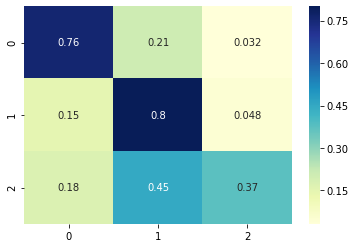

In [36]:
model_results(X_test, y_test, clf=dt1_clf)

In [37]:
d_tree_norm = [0.751, 0.760, 0.800, 0.800, 0.402, 0.375, 0.755]

#### Round 2 - Upsampling

In [38]:
#Joining back into one dataframe
df = pd.concat([X_train, y_train], axis=1)
df.status_group.value_counts()

1    21121
0    14691
2     2783
Name: status_group, dtype: int64

In [80]:
labels = ['Functional', 'Non-Functional', 'Needs Repair']
values = [21121, 14691, 2783]

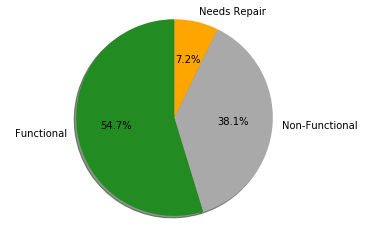

In [86]:
fig1, ax1 = plt.subplots()
ax1.pie(values, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors = ['forestgreen', 'darkgrey', 'orange'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [39]:
#Splitting into three dataframes based on class
def upsamp(df, n_samples):
    """Upsamples train data.
    
    Parameters:
    df - train dataframe
    n_samples - integer for largest group"""
    
    df_functional = df[df.status_group == 1]
    df_nonfunc = df[df.status_group == 0]
    df_repair = df[df.status_group == 2]

    #Upsampling the dataframes with less instances
    df_nonfunc_up = resample(df_nonfunc, replace=True, n_samples=n_samples, random_state=22)
    df_repair_up = resample(df_repair, replace=True, n_samples=n_samples, random_state=22)

    #Combining back to one dataframe
    df_up = pd.concat([df_functional, df_nonfunc_up, df_repair_up])
    return df_up

In [40]:
df_up = upsamp(df, 21121)

#New target variable and predictors
y_train_up = df_up.status_group
X_train_up = df_up.drop('status_group', axis=1)

#Create instance of classifier and fit training data
dt2_clf = DecisionTreeClassifier(random_state=22)
dt2_clf.fit(X_train_up, y_train_up)

DecisionTreeClassifier(random_state=22)


Classification Report
----------------
              precision    recall  f1-score   support

           0      0.756     0.729     0.742      4880
           1      0.795     0.768     0.781      7088
           2      0.321     0.472     0.382       897

    accuracy                          0.733     12865
   macro avg      0.624     0.656     0.635     12865
weighted avg      0.747     0.733     0.739     12865


Confusion Matrix
----------------


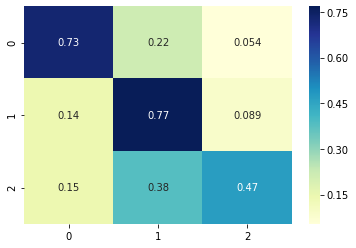

In [41]:
model_results(X_test, y_test, clf=dt2_clf)

In [42]:
d_tree_up = [0.756, 0.729, 0.795, 0.768, 0.321, 0.472, 0.733]

#### Round 3 - SMOTE

In [43]:
#Using SMOTE to balance the data
X_train, X_test, y_train, y_test = train_test_split(final_pred, target, random_state=22)
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_sample(X_train, y_train)

In [44]:
#Create instance of classifier and fit training data
dt3_clf = DecisionTreeClassifier(random_state=22)
dt3_clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=22)


Classification Report
----------------
              precision    recall  f1-score   support

           0      0.740     0.755     0.747      4880
           1      0.808     0.778     0.793      7088
           2      0.340     0.402     0.369       897

    accuracy                          0.743     12865
   macro avg      0.630     0.645     0.636     12865
weighted avg      0.750     0.743     0.746     12865


Confusion Matrix
----------------


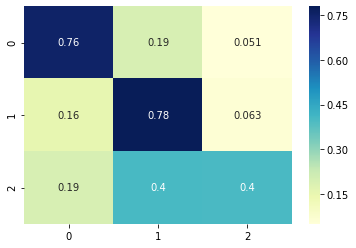

In [45]:
model_results(X_test, y_test, clf=dt3_clf)

In [74]:
d_tree_smote = [0.740, 0.755, 0.808, 0.778, 0.340, 0.402, 0.743]

## Random Forest Classifier

#### Round 1 - Unbalanced Data

In [47]:
#Random Forest Classifier
rf1_clf = RandomForestClassifier(random_state=22)
rf1_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=22)


Classification Report
----------------
              precision    recall  f1-score   support

           0      0.809     0.766     0.787      4880
           1      0.803     0.860     0.831      7088
           2      0.488     0.355     0.411       897

    accuracy                          0.789     12865
   macro avg      0.700     0.660     0.676     12865
weighted avg      0.784     0.789     0.785     12865


Confusion Matrix
----------------


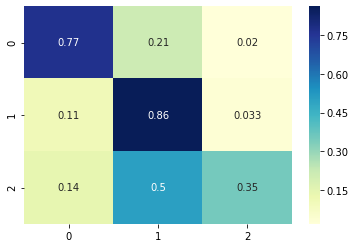

In [48]:
model_results(X_test, y_test, clf=rf1_clf)

In [49]:
r_forest_norm = [0.809, 0.766, 0.803, 0.860, 0.488, 0.355, 0.789]

#### Round 2 - Upsampling

In [50]:
#Create instance of classifier and fit training data
rf2_clf = RandomForestClassifier(random_state=22)
rf2_clf.fit(X_train_up, y_train_up)

RandomForestClassifier(random_state=22)


Classification Report
----------------
              precision    recall  f1-score   support

           0      0.804     0.752     0.777      4880
           1      0.810     0.806     0.808      7088
           2      0.347     0.480     0.403       897

    accuracy                          0.763     12865
   macro avg      0.654     0.680     0.663     12865
weighted avg      0.775     0.763     0.768     12865


Confusion Matrix
----------------


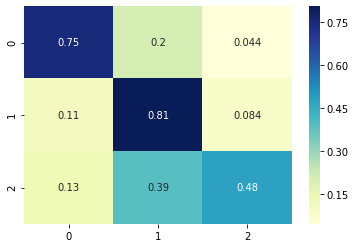

In [51]:
model_results(X_test, y_test, clf=rf2_clf)

In [52]:
r_forest_up = [0.804, 0.752, 0.810, 0.806, 0.347, 0.480, 0.763]

#### Round 3 - SMOTE

In [53]:
#Create instance of classifier and fit training data
rf3_clf = RandomForestClassifier(random_state=22)
rf3_clf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=22)


Classification Report
----------------
              precision    recall  f1-score   support

           0      0.792     0.778     0.785      4880
           1      0.817     0.824     0.821      7088
           2      0.414     0.424     0.419       897

    accuracy                          0.779     12865
   macro avg      0.674     0.675     0.675     12865
weighted avg      0.779     0.779     0.779     12865


Confusion Matrix
----------------


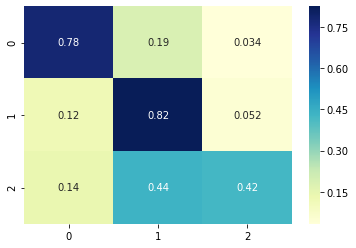

In [54]:
model_results(X_test, y_test, clf=rf3_clf)

In [75]:
r_forest_smote = [0.792, 0.778, 0.817, 0.824, 0.414, 0.424, 0.779]

## Logistic Regression

#### Round 1 - Unbalanced Data

In [56]:
#Logistic Regression
lr1_clf = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', random_state=22)
lr1_clf.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, fit_intercept=False, random_state=22,
                   solver='liblinear')


Classification Report
----------------
              precision    recall  f1-score   support

           0      0.774     0.611     0.683      4880
           1      0.710     0.902     0.795      7088
           2      0.727     0.009     0.018       897

    accuracy                          0.729     12865
   macro avg      0.737     0.507     0.498     12865
weighted avg      0.736     0.729     0.698     12865


Confusion Matrix
----------------


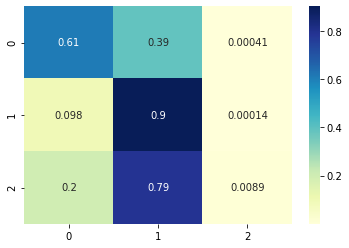

In [57]:
model_results(X_test, y_test, clf=lr1_clf)

In [58]:
log_reg_norm = [0.774, 0.611, 0.710, 0.902, 0.727, 0.009, 0.729]

#### Round 2 - Upsampling

In [59]:
#Create instance of classifier and fit training data
lr2_clf = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', random_state=22)
lr2_clf.fit(X_train_up, y_train_up)

LogisticRegression(C=1000000000000.0, fit_intercept=False, random_state=22,
                   solver='liblinear')


Classification Report
----------------
              precision    recall  f1-score   support

           0      0.779     0.610     0.684      4880
           1      0.772     0.636     0.698      7088
           2      0.168     0.602     0.263       897

    accuracy                          0.624     12865
   macro avg      0.573     0.616     0.548     12865
weighted avg      0.733     0.624     0.662     12865


Confusion Matrix
----------------


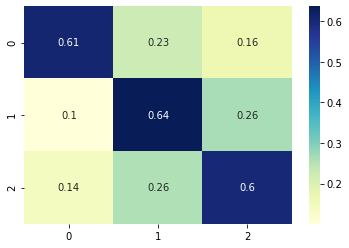

In [60]:
model_results(X_test, y_test, clf=lr2_clf)

In [61]:
log_reg_up = [0.779, 0.610, 0.772, 0.636, 0.168, 0.602, 0.624]

#### Round 3 - SMOTE

In [62]:
#Create instance of classifier and fit training data
lr3_clf = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear', random_state=22)
lr3_clf.fit(X_train_resampled, y_train_resampled)

LogisticRegression(C=1000000000000.0, fit_intercept=False, random_state=22,
                   solver='liblinear')


Classification Report
----------------
              precision    recall  f1-score   support

           0      0.761     0.585     0.661      4880
           1      0.738     0.806     0.771      7088
           2      0.211     0.324     0.256       897

    accuracy                          0.689     12865
   macro avg      0.570     0.572     0.563     12865
weighted avg      0.710     0.689     0.693     12865


Confusion Matrix
----------------


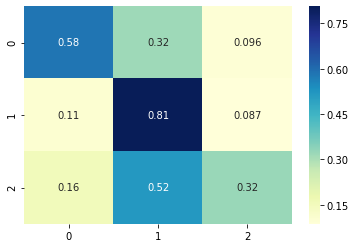

In [63]:
model_results(X_test, y_test, clf=lr3_clf)

In [76]:
log_reg_smote = [0.761, 0.585, 0.738, 0.806, 0.211, 0.324, 0.689]

## XGBoost

#### Round 1 - Unbalanced Data

In [65]:
#Logistic Regression
xg1_clf = xgb.XGBClassifier()
xg1_clf.fit(X_train, y_train)

XGBClassifier(objective='multi:softprob')


Classification Report
----------------
              precision    recall  f1-score   support

           0      0.834     0.613     0.707      4880
           1      0.718     0.934     0.812      7088
           2      0.687     0.051     0.095       897

    accuracy                          0.750     12865
   macro avg      0.746     0.533     0.538     12865
weighted avg      0.760     0.750     0.722     12865


Confusion Matrix
----------------


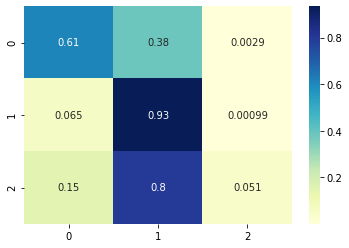

In [66]:
model_results(X_test, y_test, clf=xg1_clf)

In [67]:
xgb_norm = [0.834, 0.613, 0.718, 0.934, 0.687, 0.051, 0.750]

#### Round 2 - Upsampling

In [68]:
#Create instance of classifier and fit training data
xg2_clf = xgb.XGBClassifier()
xg2_clf.fit(X_train_up, y_train_up)

XGBClassifier(objective='multi:softprob')


Classification Report
----------------
              precision    recall  f1-score   support

           0      0.818     0.603     0.695      4880
           1      0.784     0.689     0.733      7088
           2      0.201     0.681     0.311       897

    accuracy                          0.656     12865
   macro avg      0.601     0.658     0.580     12865
weighted avg      0.756     0.656     0.689     12865


Confusion Matrix
----------------


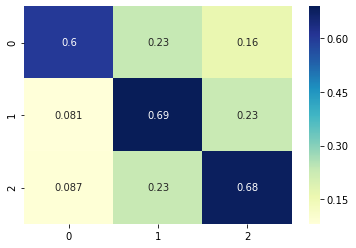

In [69]:
model_results(X_test, y_test, clf=xg2_clf)

In [70]:
xgb_up = [0.818, 0.603, 0.784, 0.689, 0.201, 0.681, 0.656]

#### Round 3 - SMOTE

In [71]:
#Create instance of classifier and fit training data
xg3_clf = xgb.XGBClassifier()
xg3_clf.fit(X_train_resampled, y_train_resampled)

XGBClassifier(objective='multi:softprob')


Classification Report
----------------
              precision    recall  f1-score   support

           0      0.795     0.605     0.687      4880
           1      0.765     0.789     0.777      7088
           2      0.230     0.470     0.309       897

    accuracy                          0.697     12865
   macro avg      0.596     0.622     0.591     12865
weighted avg      0.739     0.697     0.710     12865


Confusion Matrix
----------------


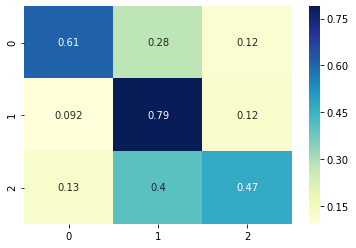

In [72]:
model_results(X_test, y_test, xg3_clf)

In [77]:
xgb_smote = [0.795, 0.605, 0.765, 0.789, 0.230, 0.470, 0.697]

## Model Comparison

In [78]:
#Recall, precision, and accuracy scores
models = pd.DataFrame([d_tree_norm, d_tree_up, d_tree_smote, r_forest_norm, r_forest_up,
                      r_forest_smote, log_reg_norm, log_reg_up, log_reg_smote, xgb_norm,
                      xgb_up, xgb_smote],
                     index= ['d_tree_norm', 'd_tree_up', 'd_tree_smote', 'r_forest_norm',
                            'r_forest_up', 'r_forest_smote', 'log_reg_norm', 'log_reg_up',
                            'log_reg_smote', 'xgb_norm', 'xgb_up', 'xgb_smote'],
                     columns= ['non_func_prec', 'non_func_rec', 'func_prec', 'func_rec',
                              'repair_prec', 'repair_rec', 'accuracy'])
models

,non_func_prec,non_func_rec,func_prec,func_rec,repair_prec,repair_rec,accuracy
d_tree_norm,0.751,0.760,0.800,0.800,0.402,0.375,0.755
d_tree_up,0.756,0.729,0.795,0.768,0.321,0.472,0.733
d_tree_smote,0.740,0.755,0.808,0.778,0.340,0.402,0.743
r_forest_norm,0.809,0.766,0.803,0.860,0.488,0.355,0.789
r_forest_up,0.804,0.752,0.810,0.806,0.347,0.480,0.763
r_forest_smote,0.792,0.778,0.817,0.824,0.414,0.424,0.779
log_reg_norm,0.774,0.611,0.710,0.902,0.727,0.009,0.729
log_reg_up,0.779,0.610,0.772,0.636,0.168,0.602,0.624
log_reg_smote,0.761,0.585,0.738,0.806,0.211,0.324,0.689
xgb_norm,0.834,0.613,0.718,0.934,0.687,0.051,0.750


Looking through these metrics for all the different models generated, if I were to submit to the competition, I would submit the Random Forest Classifier (RFC) trained on the data balanced using the SMOTE technique. 

Looking at accuracy alone, all the RFCs performed better than any other classification method. Now of those three, even though the model trained on unbalanced data had a higher accuracy score, the model trained on SMOTE-balanced data maintained a relatively high accuracy score, while also improving on the recall score for our least-populated category "Functional-Needs Repair". By improving the recall score, the model is correctly predicting a higher proportion of wells that are functional but need repair. Some of the other models have even higher recall scores for the "Functional-Needs Repair" category, but they lose out on the overall accuracy of the model.

The next step in this process would then be to adjust the hyperparameters for the `r_forest_smote` classifier to see if we can make it a little better.

## Hyperparamter Tuning

Having already established a base accuracy score of `0.779` for our RFC, using the SMOTE technique for balancing data, we can now go ahead with adjusting the hyperparameters of the model.

In [87]:
rf_params = {
    'n_estimators': [10, 30, 100, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 6, 10],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 6]
}

In [88]:
#Tuning hyperparamters
rf_grid_search = GridSearchCV(rf3_clf, rf_params, cv=3)
rf_grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=22),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 6, 10],
                         'min_samples_leaf': [3, 6],
                         'min_samples_split': [5, 10],
                         'n_estimators': [10, 30, 100, 500]})

In [89]:
print(f"Training Accuracy: {rf_grid_search.best_score_ :.2%}")
print("")
print(f"Optimal Parameters: {rf_grid_search.best_params_}")

Training Accuracy: 79.87%

Optimal Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 100}



Classification Report
----------------
              precision    recall  f1-score   support

           0      0.826     0.740     0.781      4880
           1      0.808     0.846     0.827      7088
           2      0.385     0.460     0.419       897

    accuracy                          0.779     12865
   macro avg      0.673     0.682     0.675     12865
weighted avg      0.785     0.779     0.781     12865


Confusion Matrix
----------------


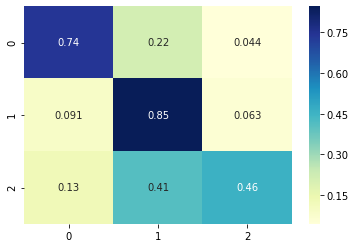

In [79]:
#Of the optimal parameters, only the 'min_samples_leaf' and 'min_samples_split' are not defaults
clf_final = RandomForestClassifier(criterion='gini', min_samples_leaf=3,
                                   min_samples_split=5, n_estimators=100, random_state=22)
clf_final.fit(X_train_resampled, y_train_resampled)
model_results(X_test, y_test, clf=clf_final)

## Model Interpretation

After tuning our hyperparameters, our overall accuracy stayed the same, our precision for the **Functional, needs repair** wells dropped by 2.9 points, and our recall for the same label increased by 3.6 points. It still isn't perfect, since almost half of the **Functional, needs repair** wells are mislabeled as **Functional** wells, but it's much better than where it was.

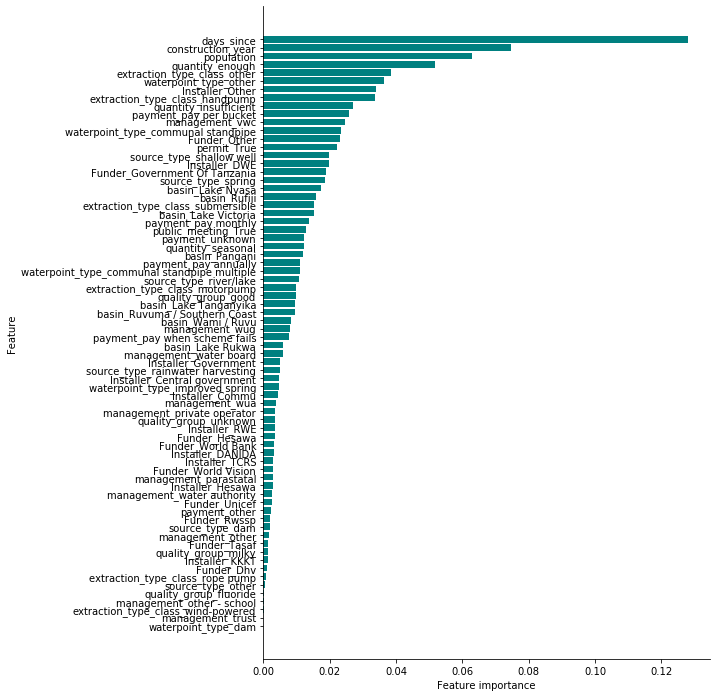

In [91]:
# Important Features
def plot_feature_importances(model):
    n_features = X_train_resampled.shape[1]
    features = model.feature_importances_
    features_indx = np.argsort(model.feature_importances_)
    plt.figure(figsize=(8,12))
    plt.barh(range(n_features), model.feature_importances_[features_indx], align='center',
            color = 'teal') 
    plt.yticks(np.arange(n_features), X_train_resampled.columns.values[features_indx]) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)

plot_feature_importances(clf_final)

Using the `feature_importances_` method, we can see that the top five important features in our model are:

1. `days_since` - the number of days before January 1st, 2014 the well was last inspected
2. `construction_year` - when the well was constructed
3. `population` - the surrounding population that uses the well
4. `quantity_enough` - whether or not there was enough water in the well
5. `extraction_type_class_other` - whether or not the well belongs to the `extraction_type_class` `other`

The first three features are all continuous variables, which the RFC model has a tendency to inflate the importance of, and the last two are dummy variables for the `quantity` and `extraction_type_class` categories.

In [94]:
df_vis = pd.concat([df_model.status_group, final_pred], axis=1)

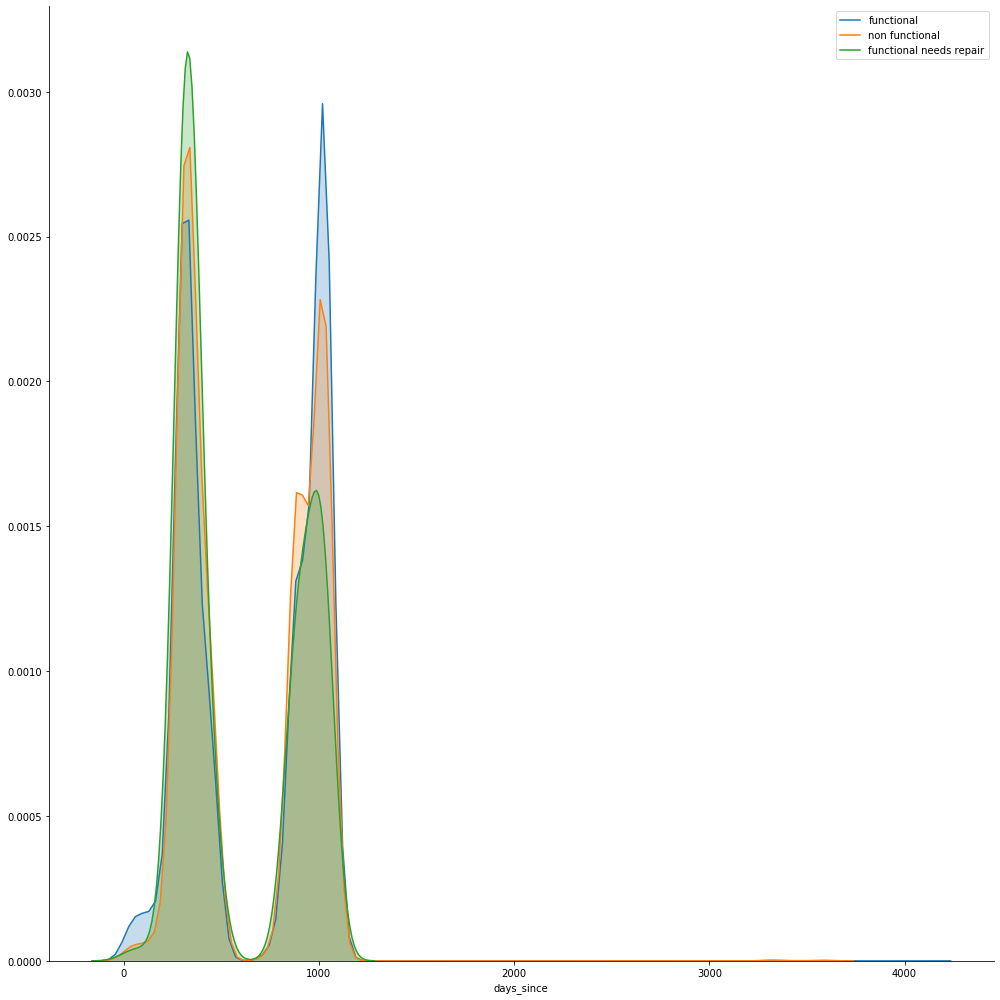

In [95]:
sns.FacetGrid(df_vis, hue='status_group',height=14).map(sns.kdeplot, 'days_since', shade=True)
plt.legend()
plt.show()

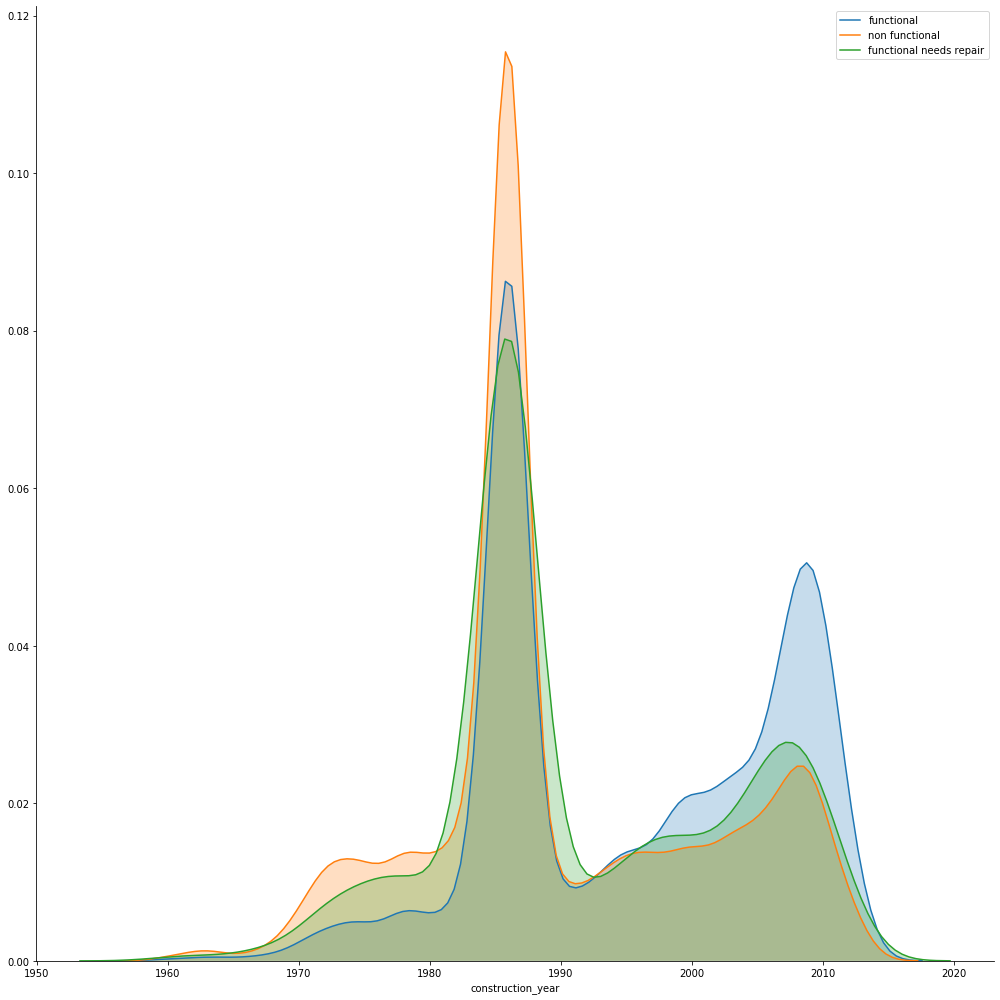

In [96]:
sns.FacetGrid(df_vis, hue='status_group',height=14).map(sns.kdeplot, 'construction_year', shade=True)
plt.legend()
plt.show()

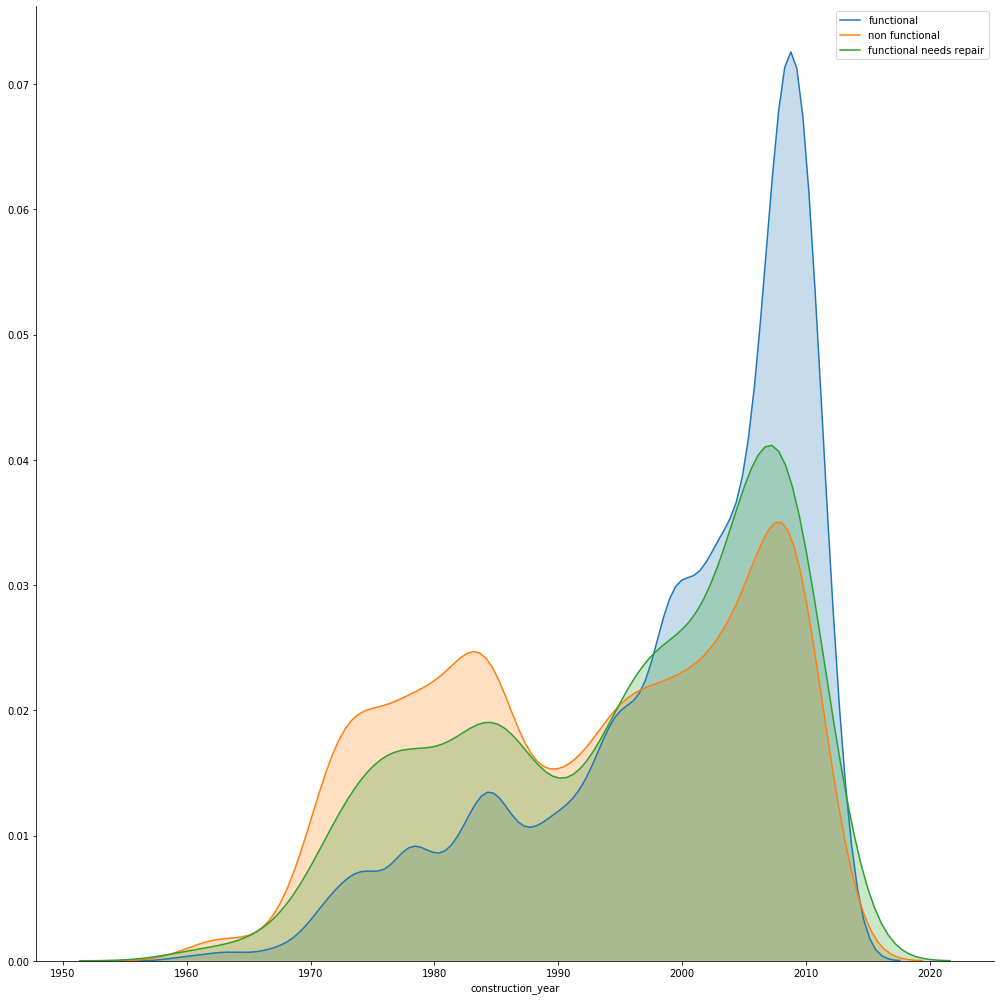

In [76]:
sns.FacetGrid(df_vis, hue='status_group',height=14).map(sns.kdeplot, 'construction_year', shade=True)
plt.legend()
plt.show()

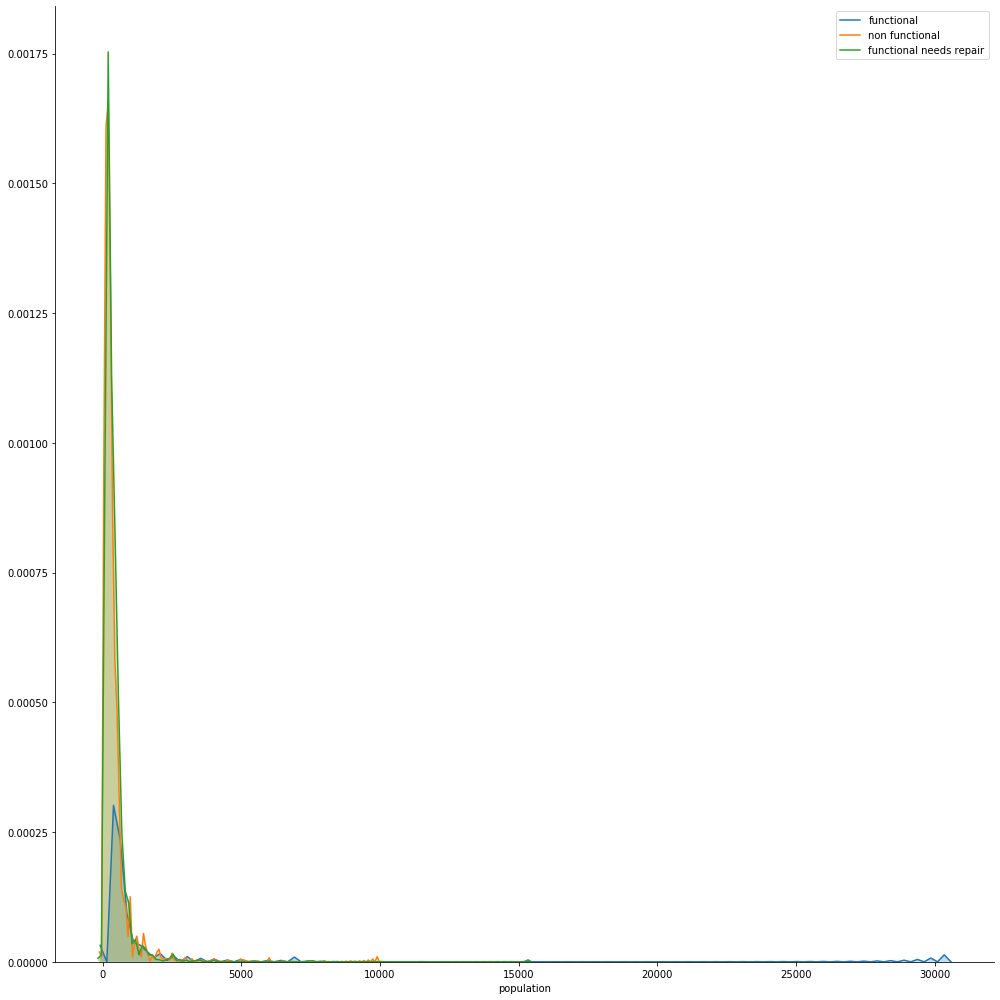

In [78]:
sns.FacetGrid(df_vis, hue='status_group',height=14).map(sns.kdeplot, 'population', shade=True)
plt.legend()
plt.show()

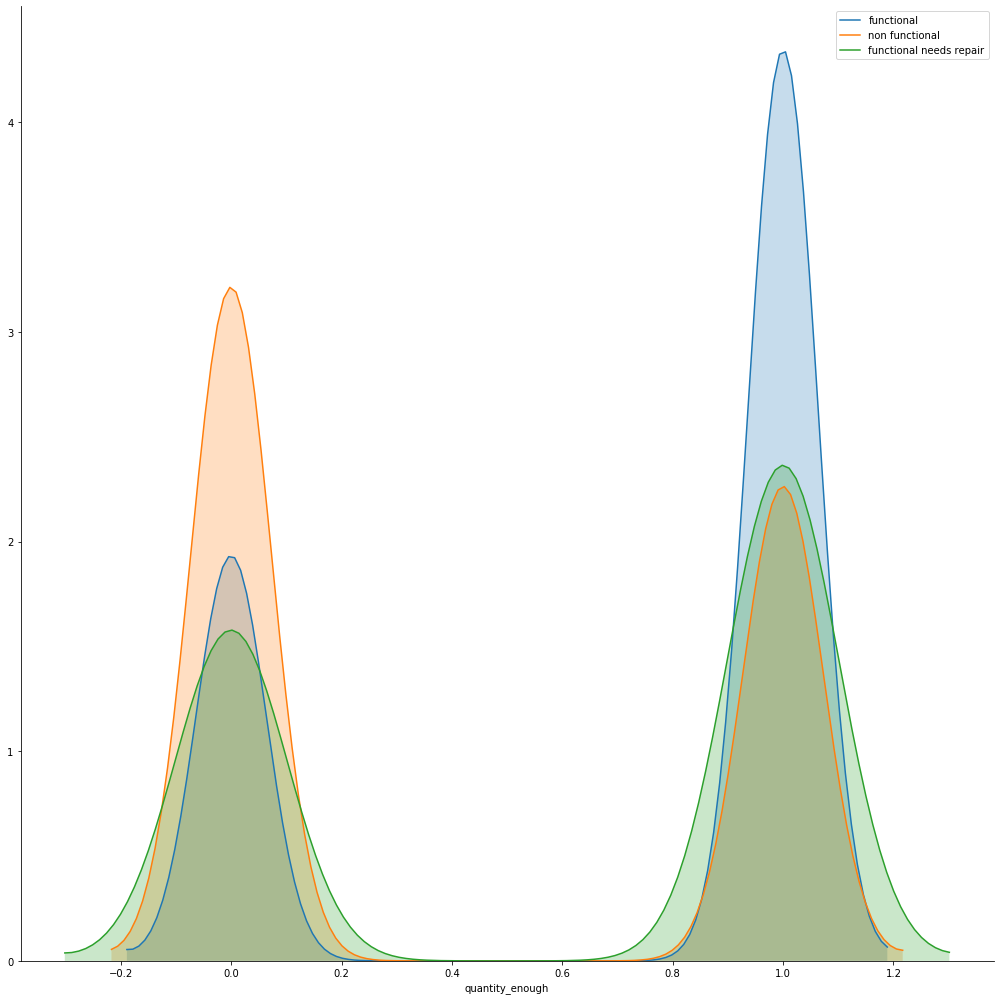

In [97]:
sns.FacetGrid(df_vis, hue='status_group',height=14).map(sns.kdeplot, 'quantity_enough', shade=True)
plt.legend()
plt.show()

In [82]:
df_vis.status_group.value_counts()

functional                 19525
non functional             12280
functional needs repair     2273
Name: status_group, dtype: int64

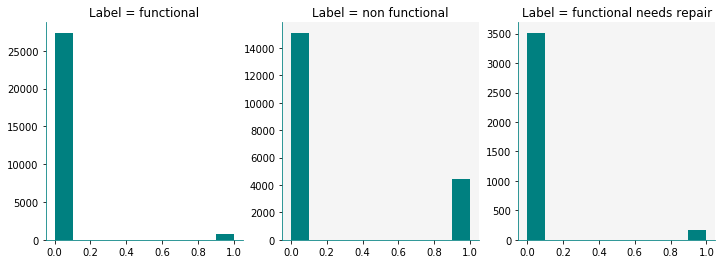

In [98]:
plt.figure(figsize=(12,4))
labels = ['functional', 'non functional', 'functional needs repair']

for k, lab in enumerate(labels):
    plt.subplot(1,3,k+1)
    plt.title("Label = {}".format(lab))
    new_df = df_vis[df_vis['status_group'] == lab]
    plt.hist(new_df['extraction_type_class_other'], color='teal')
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_color('teal')
    plt.gca().spines['bottom'].set_color('teal')
    plt.rcParams['axes.facecolor'] = 'whitesmoke'

After looking at the density plots for the top 5 most important variables, we're able to conclude the following:
1. `Non-functional` and `Functional wells that need repair` are more likely to have had an inspection closer to January of 2014 (most likely during 2013), while the `Functional` wells show equal probability of having last had their inspection in 2013 or a couple years earlier (most likely in 2011).
2. `Functional` wells are more likely to have been built in the year 2000 or later.
3. Wells with very large surrounding populations (outliers in the dataset) usually have `Functional` wells, while wells with lower surrounding populations, are likely to be `Non-functional` or `Functional, but in need of repair`.
4. `Functional wells` and `Functional wells that need repair` are more likely to have enough water in their aquifers, while `Non-functional` wells are more likely to not have enough water.
5. The last feature of importance is not too helpful, as all well types are less likely to be of the `extraction_type_class` `other`.

## Further Exploration: Data Reclassification

Currently, each well has one of the following labels:
1. Functional
2. Non functional
3. Functional, needs repair

I would argue that though the competition is looking for a model that most accurately classifies a well with one of these three labels, it might make more sense to create three different models (maybe even four). You could separate out the labels and run the following classification models in an attempt to get even more accurate results and better recall: 

1. `Functional` and `Non-functional`
2. `Functional` and `Functional, needs repair`
3. `Non-functional` and `Functional, needs repair`
4. `Functional` and `Non-functional`, where `Functional, needs repair` is relabeled as `Non-functional

I think the last one would be the most useful, and make the most sense, as one could argue that both a functional well in need of repair and a non-functional well would need to be identified for maintenance.